In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use("bmh")

## Neural network optimization

In [2]:
import torch
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")
target_name = "betas_dgp"
d_name = "betadgp_corrdgp_data"

train_data = pd.read_csv(os.path.join(target_path, d_name + "_train.csv"))
train_data.set_index(["Var1", "Var2"], inplace=True)
y_train = train_data[[target_name]].to_numpy()
X_train = train_data.drop([target_name], axis=1).to_numpy()

test_data = pd.read_csv(os.path.join(target_path, d_name + "_test.csv"))
test_data.set_index(["Var1", "Var2"], inplace=True)
y_test = test_data[[target_name]].to_numpy()
X_test = test_data.drop([target_name], axis=1).to_numpy()

In [4]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.5)

scaler = StandardScaler()
X_train_zscore = scaler.fit_transform(X_train)
X_validation_zscore = scaler.transform(X_validation)
X_test_zscore = scaler.transform(X_test)

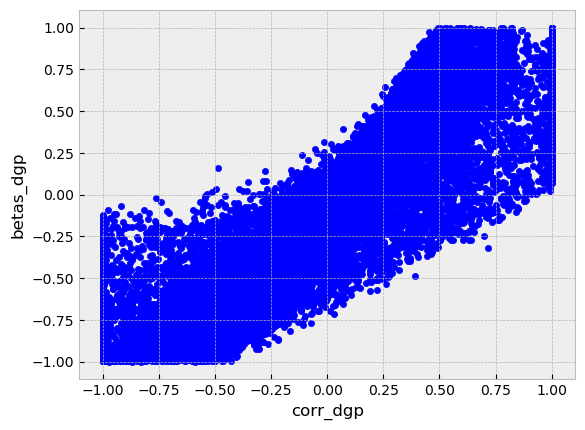

In [5]:
train_data.plot.scatter(y="betas_dgp", x="corr_dgp")

### 1) Linear regression

In [6]:
linear_reg_model = LinearRegression(fit_intercept=True)
linear_reg_model_train = linear_reg_model.fit(X=X_train_zscore, y=y_train)

linear_reg_model_predictions = linear_reg_model_train.predict(X=X_test_zscore)
preds_df = pd.DataFrame({'true': y_test.squeeze(), 'prediction': linear_reg_model_predictions.squeeze()})

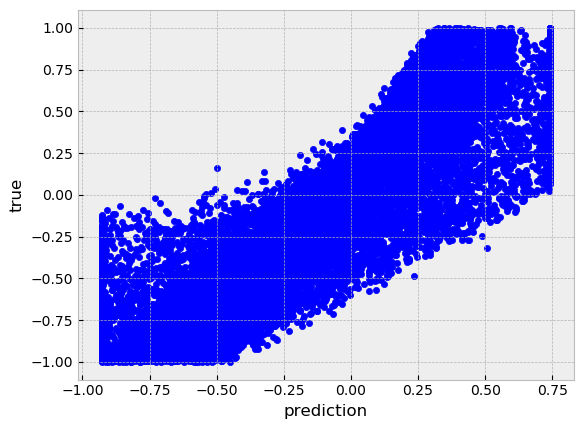

In [7]:
preds_df.plot.scatter(y="true", x="prediction")

In [8]:
print("Linear regression MSE: ", mean_squared_error(y_true=preds_df["true"], y_pred=preds_df["prediction"]))

Linear regression MSE:  0.06695049211268661


Text(0.5, 1.0, 'Linear regression')

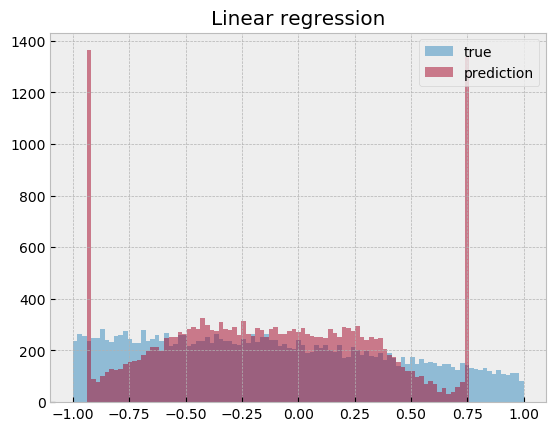

In [9]:
bins = np.linspace(preds_df.min().min(), preds_df.max().max(), 100)
for colname in preds_df.columns:
    plt.hist(preds_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("Linear regression")

### 2) Multilayer perceptron withou hyperparameters optimization

In [51]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size, bias):
            super().__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.bias = bias
            
            self.input_layer = torch.nn.Linear(self.input_size, self.hidden_size, bias=self.bias)
            self.relu = torch.nn.ReLU()
            self.hidden_layer = torch.nn.Linear(self.hidden_size, self.hidden_size, bias=self.bias)
            self.output_layer = torch.nn.Linear(self.hidden_size, 1, bias=self.bias)
        def forward(self, x):
            x = self.input_layer(x)
            
            x = self.hidden_layer(x)
            x = self.relu(x)
            x = self.hidden_layer(x)
            x = self.relu(x)
                     
            output = self.output_layer(x)
            
            return output

In [37]:
X_train_zscore_torch = torch.FloatTensor(X_train_zscore)
y_train_torch = torch.FloatTensor(y_train)

X_validation_zscore_torch = torch.FloatTensor(X_validation_zscore)
y_validation_torch = torch.FloatTensor(y_validation)

X_test_zscore_torch = torch.FloatTensor(X_test_zscore)
y_test_torch = torch.FloatTensor(y_test)

In [38]:
feed_forward_model = Feedforward(input_size=X_train.shape[1], hidden_size=10, bias=True)
feed_forward_model

Feedforward(
  (input_layer): Linear(in_features=1, out_features=10, bias=True)
  (relu): ReLU()
  (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(feed_forward_model.parameters(), lr=0.01)
optimizer.zero_grad()

epochs = 100
loss_values = []
for i in tqdm(range(epochs), total=epochs, desc="Running backpropagation"):
    # computer forward prediction
    # if first iter, use random init
    y_hat = feed_forward_model.forward(X_train_zscore_torch)

    # computes the loss function
    loss = criterion(y_hat, y_train_torch)
    loss_values.append(loss.item())

    # set all previous gradients to zero
    optimizer.zero_grad()

    # backpropagation
    # computes gradient of current tensor given loss and opt procedure
    loss.backward()
    # update parameters
    optimizer.step()

Running backpropagation: 100%|██████████| 100/100 [00:00<00:00, 328.45it/s]


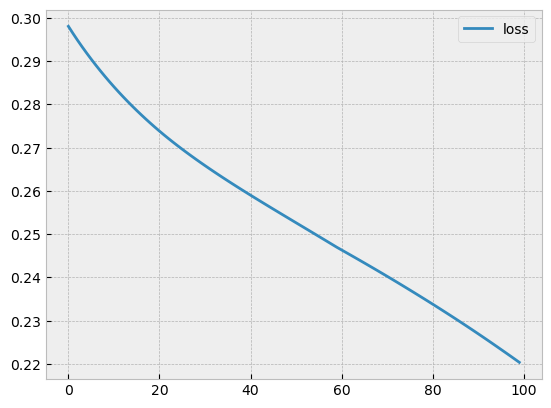

In [40]:
loss_values_df = pd.DataFrame(loss_values, columns=["loss"])
loss_values_df.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f527de890>]],
      dtype=object)

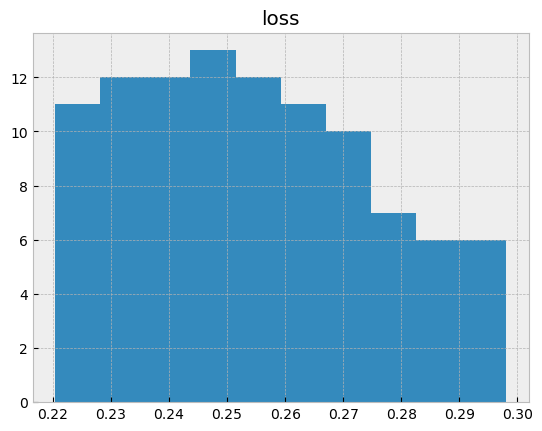

In [43]:
loss_values_df.hist()

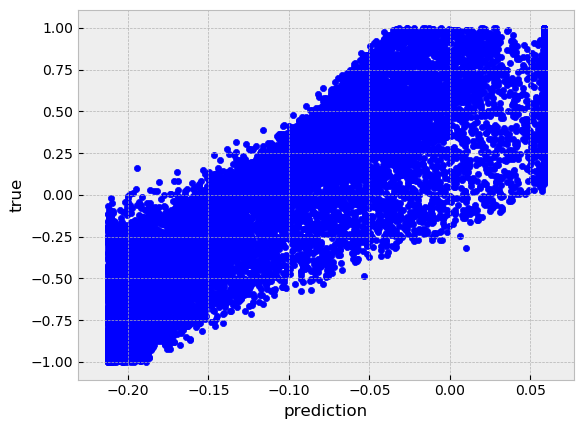

In [41]:
preds = []
with torch.no_grad():
   for val in X_test_zscore_torch:
       y_hat = feed_forward_model.forward(val)
       preds.append(y_hat.item())
preds_df = pd.DataFrame({'true': y_test_torch.squeeze(), 'prediction': preds})

preds_df.plot.scatter(y="true", x="prediction")

In [49]:
print("Neural network MSE: ", mean_squared_error(y_true=preds_df["true"], y_pred=preds_df["prediction"]))

Neural network MSE:  0.2225872021512052


Text(0.5, 1.0, 'Neural network')

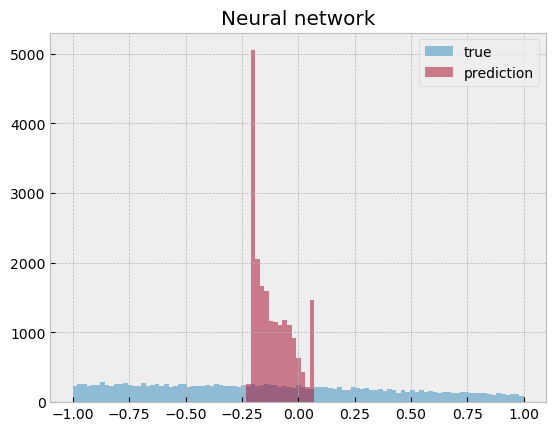

In [50]:
bins = np.linspace(preds_df.min().min(), preds_df.max().max(), 100)
for colname in preds_df.columns:
    plt.hist(preds_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("Neural network")

### 3) Multilayer perceptron with hyperparameters optimization

In [52]:
from models.neural_networks import MLP
import training.optimization as opt

In [79]:
class MLPWrapper():
    def __init__(self, 
                 learning_rate=None,
                 n_units=None,
                 n_layers=None,
                 optimizer=None,
                 input_size=None,
                 trial=None):

        self.model_name = "mlp"
        self.search_type = 'random'

        learning_rate = learning_rate if learning_rate is not None else trial.suggest_float("learning_rate", 1e-2, 1e-1)
        n_units = n_units if n_units is not None else trial.suggest_int("n_unit", 5, 10)
        n_layers = n_layers if n_layers is not None else trial.suggest_int("n_layers", 2, 10)
        optimizer = optimizer if optimizer is not None else trial.suggest_categorical("optimizer", ["SGD"])
        input_size = trial.suggest_int("input_size", input_size, input_size)

        self.params = {
              'learning_rate': learning_rate,
              'n_units': n_units,
              'n_layers': n_layers,
              'optimizer': optimizer,
              'input_size': input_size,
              }
        self.epochs = 10000

        self.ModelClass = MLP(input_size=self.params["input_size"],
                              n_layers=self.params["n_layers"],
                              n_units=self.params["n_units"],
                              bias=True)

In [80]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=2294))
study.optimize(lambda trial: opt.objective(

    y_train=y_train_torch,
    X_train=X_train_zscore_torch,
    y_validation=y_validation_torch,
    X_validation=X_validation_zscore_torch,
    X_test=X_test_zscore_torch,
    model_wrapper=MLPWrapper,
    criterion=criterion,
    verbose=False,
    trial=trial

    ), n_trials=10, n_jobs=2)

[I 2023-01-30 20:35:09,780] A new study created in memory with name: no-name-6c61ab12-2241-4a4a-8689-c205c405dc8f
[I 2023-01-30 20:35:45,061] Trial 8 finished with value: 0.3270568251609802 and parameters: {'learning_rate': 0, 'n_unit': 8, 'n_layers': 9, 'optimizer': 'SGD', 'input_size': 1}. Best is trial 1 with value: 0.30964019894599915.
[I 2023-01-30 20:35:46,964] Trial 7 finished with value: 0.31038159132003784 and parameters: {'learning_rate': 0, 'n_unit': 9, 'n_layers': 10, 'optimizer': 'SGD', 'input_size': 1}. Best is trial 1 with value: 0.30964019894599915.
[I 2023-01-30 20:36:00,604] Trial 1 finished with value: 0.05490955337882042 and parameters: {'learning_rate': 0.08979823288645755, 'n_unit': 9, 'n_layers': 2, 'optimizer': 'SGD', 'input_size': 1}. Best is trial 1 with value: 0.05490955337882042.
[I 2023-01-30 20:36:14,872] Trial 0 finished with value: 0.05520631745457649 and parameters: {'learning_rate': 0.05407185093796026, 'n_unit': 6, 'n_layers': 4, 'optimizer': 'SGD', '

In [81]:
study.best_trial.user_attrs.keys()

dict_keys(['loss_values', 'validation_loss', 'test_predictions'])

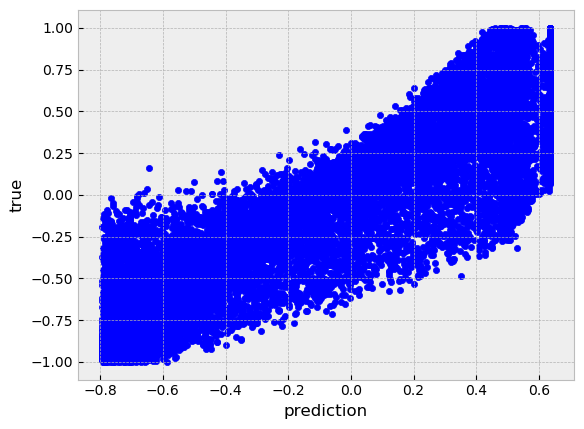

In [82]:
preds_df = pd.DataFrame({'true': y_test.squeeze(), 'prediction': study.best_trial.user_attrs["test_predictions"].squeeze()})
preds_df.plot.scatter(y="true", x="prediction")

In [83]:
print("Neural network MSE: ", mean_squared_error(y_true=preds_df["true"], y_pred=preds_df["prediction"]))

Neural network MSE:  0.05498146097737073


Text(0.5, 1.0, 'Neural network')

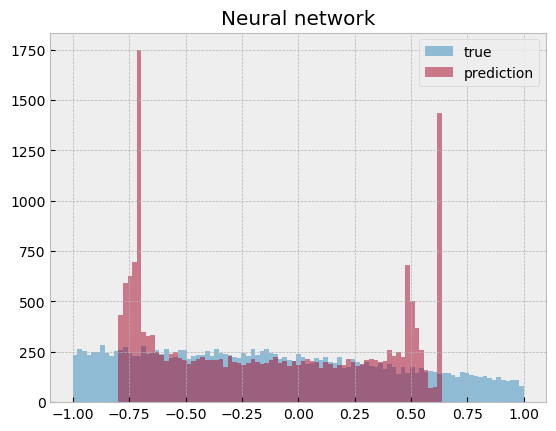

In [84]:
bins = np.linspace(preds_df.min().min(), preds_df.max().max(), 100)
for colname in preds_df.columns:
    plt.hist(preds_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("Neural network")

## Simple AR simulation analysis

In [23]:
arparams = np.array([.75, -.25])
ar = np.r_[1, -arparams]
maparams = np.array([0, 0])
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)

sm.tsa.ARIMA(endog=y, order=(2, 0, 0), trend="n").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -345.284
Date:                Mon, 30 Jan 2023   AIC                            696.569
Time:                        07:03:49   BIC                            707.133
Sample:                             0   HQIC                           700.821
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8841      0.065     13.557      0.000       0.756       1.012
ar.L2         -0.2838      0.066     -4.317      0.000      -0.413      -0.155
sigma2         0.9242      0.088     10.535      0.000       0.752       1.096
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.97   Prob(JB):                         0.89
Heteroskedasticity (H):               1.30   Skew:                             0.04
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Simulate from multiple stationary AR models

In [24]:
alpha = 0.05
i = 0
summary = {}
while i < 10000:

    arparams = np.array([np.random.uniform(low=-1, high=1, size=1)[0], np.random.uniform(low=-1, high=1, size=1)[0]])
    ar = np.r_[1, -arparams]
    maparams = np.array([0, 0])
    ma = np.r_[1, maparams]
    y = sm.tsa.arma_generate_sample(ar, ma, 100)

    if sm.tsa.stattools.adfuller(y)[1] <= alpha:
        summary[i] = {"y": y, "coefs": arparams}
        i += 1

KeyboardInterrupt: 

### Compute statistics from simulated data to be used on the prediction taks

In [ ]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"betas_dgp": summary[i]["coefs"][l-1], "beta_2x2": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "cov_dgp": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "corr_dgp": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)
corr2x2_df = pd.concat(corr2x2, axis=0)

corr2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_corrdgp_data.csv"), index=False)
cov2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_covdgp_data.csv"), index=False)
betadgp_beta2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_beta2x2_data.csv"), index=False)

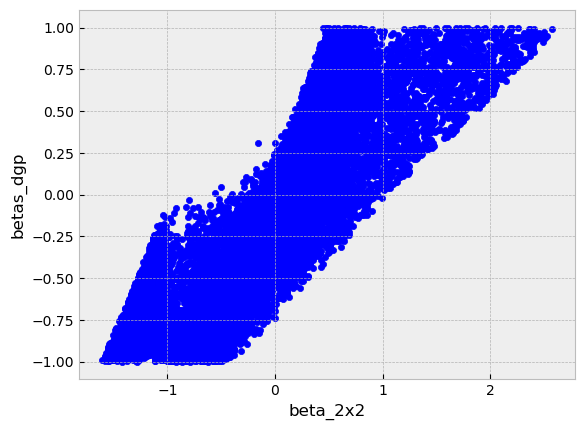

In [ ]:
betadgp_beta2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="beta_2x2")

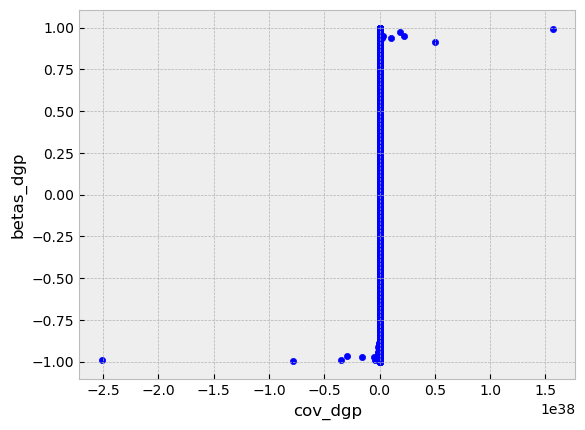

In [ ]:
cov2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="cov_dgp")

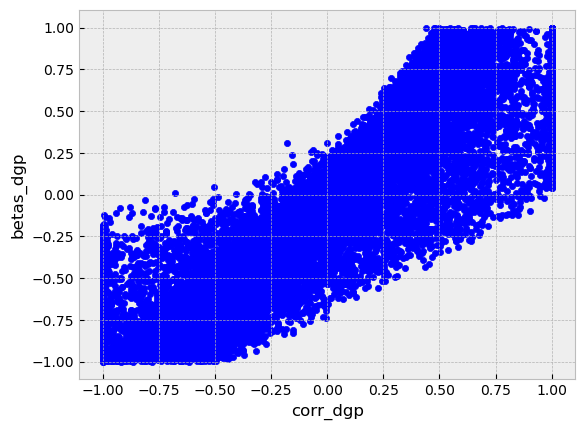

In [ ]:
corr2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="corr_dgp")

In [ ]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"betas_dgp": summary[i]["coefs"][l-1], "beta_2x2": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "cov_dgp": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "corr_dgp": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)
corr2x2_df = pd.concat(corr2x2, axis=0)

corr2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_corrdgp_data_test.csv"), index=False)
cov2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_covdgp_data_test.csv"), index=False)
betadgp_beta2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_beta2x2_data_test.csv"), index=False)